<a href="https://colab.research.google.com/github/ZachFunk/3D-GAP-Masters-Thesis/blob/main/UMVD_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIP

In [1]:
! nvidia-smi
!pip install pytorch-lightning
!pip install tifffile
!pip install imagecodecs
!pip install pytorch_msssim
!pip install wandb
from google.colab import drive
drive.mount('/content/drive')
!pip install -r /content/drive/MyDrive/MastersThesis/UMVD-main/requirement.txt

Mon Sep  2 08:37:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

MessageError: Error: credential propagation was unsuccessful

# Imports

In [ ]:
import sys
#sys.path.append('/content/drive/MyDrive/MastersThesis/UMVD-main')
import argparse
import logging
import sys
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from tqdm.notebook import tqdm
from PIL import Image
import random
# import imageio as io
import torchmetrics

import numpy as np
sys.path.append('/content/drive/MyDrive/MastersThesis/UMVD-main/model.py')

import tifffile as tiff
import imagecodecs
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


sys.path.append('/content/drive/MyDrive/MastersThesis/UMVD-main/utils')

################################################################################
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
#from ProcessData import *
from pytorch_lightning.loggers import WandbLogger
################################################################################

# %load_ext autoreload
# %autoreload

seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

data = tiff.imread('/content/drive/MyDrive/MastersThesis/data/clean_30Hz_256x256x(0-1000).tif')
data = torch.from_numpy(data)
#data = data.to(device)

# Create Data

## Functions

In [ ]:
def add_poisson_noise(data, noise_scale):
    #normalize between 0, 255
    data = (data - data.min()) / (data.max() - data.min()) * 255
    noisy_data = torch.poisson(data * noise_scale) / noise_scale
    return data, noisy_data


def process_data(data, noise_scale, device='cpu', test=True):
    # Move data to the specified device
    data = data.to(device)

    gt_data, noisy_data = add_poisson_noise(data, noise_scale)
    gt_data, noisy_data = gt_data.to(device), noisy_data.to(device)

    snr = calculate_snr(gt_data, noisy_data)
    rounded_snr = round(snr)

    _, _, gt_test, noisy_train, noisy_val, noisy_test = split_data(gt_data, noisy_data)

    # Move results back to CPU before returning
    gt_test = gt_test.to('cpu')
    noisy_test = noisy_test.to('cpu')
    noisy_train = noisy_train.to('cpu')
    noisy_val = noisy_val.to('cpu')

    temp_dict = {}
    if test:
        temp_dict[rounded_snr] = {
            'noisy_test': noisy_test,
            'gt_test': gt_test
        }
    else:
        temp_dict[rounded_snr] = {
            'noisy_train': noisy_train,
            'noisy_val': noisy_val
        }

    return temp_dict


def calculate_snr(gt_data, noisy_data):
    """
    Calculate the overall SNR for a dataset of images with channel dimension.

    Parameters:
    - gt_data (torch.Tensor): The ground truth image tensor. Should be of shape (N, H, W).
    - noisy_data (torch.Tensor): The noisy image tensor. Should be of shape (N, H, W).

    Returns:
    - overall_snr_db (float): The overall SNR for the dataset in dB.
    """

    # Calculate signal power for all images at once
    signal_power = torch.mean(gt_data ** 2, dim=(-1, -2,-3))

    # Calculate noise for all images at once
    noise = noisy_data - gt_data

    # Calculate noise power for all images at once
    noise_power = torch.mean(noise ** 2, dim=(-1, -2,-3))

    # Calculate overall SNR for all images
    overall_snr = torch.mean(signal_power / noise_power)

    # Convert to dB
    overall_snr_db = 10 * torch.log10(overall_snr)

    return overall_snr_db.item()



def split_data(ground_truth, noisy_data, train_ratio=0.7, val_ratio=0.15):
    """
    Splits ground truth and noisy data into train, validation, and test sets.

    Parameters:
    - ground_truth: PyTorch tensor of ground truth data
    - noisy_data: PyTorch tensor of noisy data
    - train_ratio: proportion of data to be used for training
    - val_ratio: proportion of data to be used for validation

    Returns:
    - gt_train, gt_val, gt_test: ground truth data splits as PyTorch tensors
    - noisy_train, noisy_val, noisy_test: noisy data splits as PyTorch tensors
    """

    # Check if data tensors are of the same length
    if ground_truth.size(0) != noisy_data.size(0):
        raise ValueError("Ground truth and noisy data must have the same length.")

    # Compute split indices
    total_sequences = ground_truth.size(0)
    train_end = int(total_sequences * train_ratio)
    val_end = int(total_sequences * (train_ratio + val_ratio))

    # Split the data
    gt_train = ground_truth[:train_end]
    gt_val = ground_truth[train_end:val_end]
    gt_test = ground_truth[val_end:]

    noisy_train = noisy_data[:train_end]
    noisy_val = noisy_data[train_end:val_end]
    noisy_test = noisy_data[val_end:]

    return gt_train, gt_val, gt_test, noisy_train, noisy_val, noisy_test


## Create Data

In [ ]:
# Define noise levels
test_noise_values = [0.0000094, 0.0000298, 0.000100, 0.0003, 0.00095, 0.003, 0.0095, 0.030,
                     0.094,
                     0.30,0.95,2.99]

train_noise_values = [3.0]

# Initialize dictionaries
test_dict = {}
train_dict = {}

# Process test data
for noise in test_noise_values:
    results = process_data(data, noise_scale=noise, test=True, device=device)
    test_dict.update(results)

# Process training data
for noise in train_noise_values:
    results = process_data(data, noise_scale=noise, test=False, device=device)
    train_dict.update(results)

# Get the SNR keys of the dictionaries
snr_keys_train = list(train_dict.keys())
snr_keys_test = list(test_dict.keys())

# Access inner keys using the SNR key
inner_keys_train = train_dict[snr_keys_train[0]].keys() if snr_keys_train else []
inner_keys_test = test_dict[snr_keys_test[0]].keys() if snr_keys_test else []

print(f'Train PSNR: {snr_keys_train}')
print(f'  Datasets: {list(inner_keys_train)}\n')

print(f'Test PSNR: {snr_keys_test}')
print(f' Datasets: {list(inner_keys_test)}')

print()

Train PSNR: [15]
  Datasets: ['noisy_train', 'noisy_val']

Test PSNR: [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15]
 Datasets: ['noisy_test', 'gt_test']



# NAOMi Data

In [ ]:
class Naomi_data(torch.utils.data.Dataset):
    def __init__(self, data, patch_size=None, stride=64, n_frames=5, test_data = False):
        super().__init__()
        self.files = data
        self.size = patch_size
        self.stride = stride
        self.len = 0
        self.bounds = [0]
        self.nHs = []
        self.nWs = []
        self.n_frames = n_frames
        self.test_data = test_data



        if self.size is not None:
            # print(self.files.shape)
            # (h, w) = np.array(cv2.imread(self.files[0], cv2.IMREAD_GRAYSCALE)).shape
            (h, w) = self.files[0].shape
            self.nH = (int((h-self.size)/self.stride)+1)
            self.nW = (int((w-self.size)/self.stride)+1)
            #print(nH)
            self.n_patches = self.nH * self.nW
            self.len += len(self.files) * self.nH * self.nW
            self.nHs.append(self.nH)
            self.nWs.append(self.nW)
            # print(self.nHs)
        else:
            self.len += len(self.files)
        self.bounds.append(self.len)

        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        # print(index)
        ends = 0
        x = (self.n_frames-1) // 2
        for i, bound in enumerate(self.bounds):
            if index < bound:
                index -= self.bounds[i-1]
                newbound = bound - self.bounds[i-1]
                if self.size is not None:
                    nH = self.nHs[i-1]
                    nW = self.nWs[i-1]
                    patch = index % (nH*nW)
                    index = index // (nH*nW)
                    newbound = newbound // (nH*nW)
                if(index < x):
                    ends = x-index
                elif(newbound-1-index < x):
                    ends = -(x-(newbound-1-index))
                break

        # img = cv2.imread(self.files[index], cv2.IMREAD_GRAYSCALE)
        noisy_img = self.files[index]
        noisy_Img = np.expand_dims(np.array(noisy_img), axis=0)

        for i in range(1,x+1):
            end = max(0, ends)
            off = max(0,i-x+end)


            noisy_img = self.files[index-i+off]
            noisy_img = np.expand_dims(np.array(noisy_img), axis=0)
            noisy_Img = np.concatenate((noisy_img, noisy_Img), axis=0)

        for i in range(1,x+1):
            end = -min(0,ends)
            off = max(0,i-x+end)

            noisy_img = self.files[index+i-off]
            noisy_img = np.expand_dims(np.array(noisy_img), axis=0)
            noisy_Img = np.concatenate((noisy_Img, noisy_img), axis=0)

        if self.size is not None:
            nh = (patch // nW)*self.stride
            nw = (patch % nW)*self.stride
            noisy_Img = noisy_Img[:, nh:(nh+self.size), nw:(nw+self.size)]
        # print(Img.shape)
        # self.transform(np.array(Img[i]))

        noisy_Img = np.expand_dims(noisy_Img, axis=3)
        noisy_Img = torch.stack([self.transform(np.array(noisy_Img[i])).type(torch.FloatTensor) for i in range(self.n_frames)], axis=0)

        if self.test_data == False:
          return noisy_Img




# Dataloader

In [ ]:
noisy_train = train_dict[15].get('noisy_train')
noisy_val = train_dict[15].get('noisy_val')


noisy_train = np.array(noisy_train).astype(np.float32)
noisy_val = np.array(noisy_val).astype(np.float32)


print(f'Noisy train shape:       {noisy_train.shape}')
print(f'Noisy Val Shape:         {noisy_val.shape}')

Noisy train shape:       (700, 256, 256)
Noisy Val Shape:         (150, 256, 256)


In [ ]:
# Arguemtents for model and dataloader
batch_size = None
image_size = 128
n_frames = 5
stride = 64
level = 64
minv = 0.0
filters = 21
in_channels = 1
out_channels = 1
bias = False
loss_fn = "mse"
lr = 1e-3
valid_interval = 1


    # Create datasets
train_dataset = Naomi_data(noisy_train, patch_size=image_size, stride=stride, n_frames=n_frames, test_data = False)
val_dataset = Naomi_data(noisy_val, patch_size=None, stride=stride, n_frames=n_frames, test_data = False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

img = next(iter(train_loader))
print(img.shape)

torch.Size([5, 1, 128, 128])


# MODEL

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


def temporalfilter(n_frames, mid=None, level=1, minv=0, maxv=1, device='cpu'):
    if mid is None:
        mid = n_frames // 2

    # Create the x tensor
    x = torch.linspace(0, 2 * mid, n_frames, device=device)

    # Compute the y tensor
    y = torch.where(x <= mid,
                    1 - (x / mid) ** level,
                    1 - ((2 * mid - x) / mid) ** level)

    # Scale to the range [minv, maxv]
    y = y * (maxv - minv) + minv

    return y


class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, bias=False):
        super().__init__()
        self.replicate = nn.ReplicationPad2d(1)
        self.conv = nn.Conv2d(in_channels, out_channels, 3, bias=bias)
        # self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.replicate(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


class Pool(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool(x)
        return x



class DepthwiseConv(nn.Module):
    def __init__(self, in_channels, out_channels, group, bias=False):
        super().__init__()
        self.replicate = nn.ReplicationPad2d(1)
        self.depthconv = nn.Conv2d(in_channels, out_channels, kernel_size=3, groups=group, bias=bias)
        # self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.replicate(x)
        x = self.depthconv(x)
        x = self.relu(x)
        return x


class ENC_Conv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, bias=False, reduce=True):
        super().__init__()
        self.reduce = reduce
        self.conv1 = Conv(in_channels, mid_channels, bias=bias)
        self.conv2 = Conv(mid_channels, mid_channels, bias=bias)
        self.conv3 = Conv(mid_channels, mid_channels, bias=bias)
        self.conv4 = Conv(mid_channels, mid_channels, bias=bias)
        self.conv5 = Conv(mid_channels, out_channels, bias=bias)
        if reduce:
            self.pool = Pool()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        if self.reduce:
            x = self.pool(x)
        return x

class DEC_Conv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, bias=False):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = Conv(in_channels, mid_channels, bias=bias)
        self.conv2 = Conv(mid_channels, mid_channels, bias=bias)
        self.conv3 = Conv(mid_channels, mid_channels, bias=bias)
        self.conv4 = Conv(mid_channels, mid_channels, bias=bias)
        self.conv5 = Conv(mid_channels, mid_channels, bias=bias)
        self.conv6 = Conv(mid_channels, out_channels, bias=bias)


    def forward(self, x, x_in):
        x = self.upsample(x)

        # Smart Padding
        diffY = x_in.size()[2] - x.size()[2]
        diffX = x_in.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])

        x = torch.cat((x, x_in), dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        return x



class Denoiser(pl.LightningModule):
    def __init__(self, in_channels=3, n_output=3, filters=21, bias=False, n_frames=7, level=1, minv=0):
        super(Denoiser, self).__init__()
        self.save_hyperparameters()
        self.in_channels = in_channels
        self.bias = bias
        self.n_f = n_frames
        self.c = in_channels
        self.mid = n_frames // 2
        mid_channels = filters*self.c
        self.convout = mid_channels
        group = in_channels
        self.conv1 = DepthwiseConv(in_channels, mid_channels, group=group, bias=bias)
        self.conv2 = DepthwiseConv(mid_channels, mid_channels, group=group, bias=bias)
        self.conv3 = DepthwiseConv(mid_channels, self.convout, group=group, bias=bias)

        enc_channels = self.convout*n_frames
        # enc_channels = 3*n_frames
        self.enc1 = ENC_Conv(enc_channels, 48, 48, bias=bias)
        self.enc2 = ENC_Conv(48, 48, 48, bias=bias)
        self.enc3 = ENC_Conv(48, 96, 48, bias=bias, reduce=False)
        self.dec2 = DEC_Conv(96, 96, 96, bias=bias)
        self.dec1 = DEC_Conv(96+enc_channels, 96, 96, bias=bias)


        self.out1 = nn.Conv2d(96, 384, 1, bias=bias)
        self.out2 = nn.Conv2d(384, 96, 1, bias=bias)
        self.out3 = nn.Conv2d(96, n_output, 1, bias=bias)

        mid = n_frames//2
        LEVEL, MINV = level, minv
        self.weights = torch.tensor(temporalfilter(n_frames, mid, LEVEL, MINV)).unsqueeze(1).float().to(device)
        # print(f'LEVEL = {LEVEL}')

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, input):
        B, C, H, W = input.shape

        x = self.conv1(input)
        x = self.conv2(x)
        x_conv = self.conv3(x)

        x = torch.cat([self.weights[i] * x_conv[(i):(i+1),:,:,:] for i in range(self.n_f)], dim=0)
        x = torch.reshape(x, (1, B*self.convout, H, W))

        input = x

        x1 = self.enc1(input)
        x2 = self.enc2(x1)
        x = self.enc3(x2)
        x = self.dec2(x, x1)
        x = self.dec1(x, input)

        x = F.relu_(self.out1(x))
        x = F.relu_(self.out2(x))
        x = self.out3(x)

        return x


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
        }


    def loss_function(self, output, target):
      return F.mse_loss(output, target, reduction="sum") / (target.size(0) * 2)


    def training_step(self, batch, batch_idx):
        input = batch
        target = batch[(self.mid):(self.mid+1),...]
        loss = self.loss_function(self(input),target)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input = batch
        target = batch[(self.mid):(self.mid+1),...]
        loss = self.loss_function(self(input),target)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        input = batch
        target = batch[(self.mid):(self.mid+1),...]
        loss = self.loss_function(self(input),target)
        self.log("test_loss", loss)

# Intialize Model

In [ ]:
maxepochs = 10

model =  Denoiser(in_channels=
                  in_channels,
                  n_output=out_channels,
                  filters=filters,
                  bias=bias,
                  n_frames=n_frames,
                  level=level,
                  minv=minv).to(device)

cpf = model.c # channels per frame
model.train()

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)


name = f'UMVD: Params: {num_params}, n_frames: {n_frames}, Filters {filters}, Level:{level}'
print(name)
CHECKPOINT_PATH = '/content/drive/MyDrive/MastersThesis/Analysis/Checkpoints/'+ name

# Create the directory if it does not exist
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Cast to weights and biases
wandb_logger = WandbLogger(
    project='My GAP',
    name = name,
    log_model=True

)


# Define ModelCheckpoint callback with save_top_k
checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_PATH,  # Directory to save checkpoints
    filename='{epoch}-{val_loss:.2f}',  # Filename format for checkpoints
    save_weights_only=False,
    mode='min',  # Monitor mode
    monitor='val_loss',  # Metric to monitor
    save_top_k=-1  # Save all checkpoints
)

# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    default_root_dir=CHECKPOINT_PATH,  # Directory for logs and checkpoints
    gradient_clip_val=0.5,
    accelerator='gpu',
    max_epochs=maxepochs,
    callbacks=[
        checkpoint_callback,  # ModelCheckpoint callback
        LearningRateMonitor("epoch"),
        EarlyStopping('val_loss', patience=2000)
    ],
    logger=wandb_logger
)

<ipython-input-10-8d066055593e>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(temporalfilter(n_frames, mid, LEVEL, MINV)).unsqueeze(1).float().to(device)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


1731759
UMVD: Params: 1731759, n_frames: 5, Filters 21, Level:64


In [ ]:
# If Checkpoint Exists
import os

def find_file(root_folder, filename):
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file == filename:
                return os.path.join(root, file)
    return None

checkpoint_path = find_file(CHECKPOINT_PATH,
                            'epoch=9-val_loss=394968.03.ckpt')
if checkpoint_path is None:
  checkpoint_path = 'NULL'
print(checkpoint_path)


NULL


# Run Model

In [ ]:
checkpoint_path = None
# Check if the checkpoint exists
if checkpoint_path is not None and os.path.isfile(checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    # Load the state_dict from the checkpoint into the model
    model.load_state_dict(checkpoint['state_dict'])
    # Initialize trainer with the loaded model
    trainer.fit(model, train_loader, val_loader, ckpt_path=checkpoint_path)
else:
    print("No checkpoint found. Starting training from scratch.")
    trainer.fit(model, train_loader, val_loader)

# Save a checkpoint after training
trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

No checkpoint found. Starting training from scratch.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

# Inference

<ipython-input-10-8d066055593e>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(temporalfilter(n_frames, mid, LEVEL, MINV)).unsqueeze(1).float().to(device)
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Testing PSNRs [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15]
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 6.493102073669434
Denoised mean: 23.64707374572754


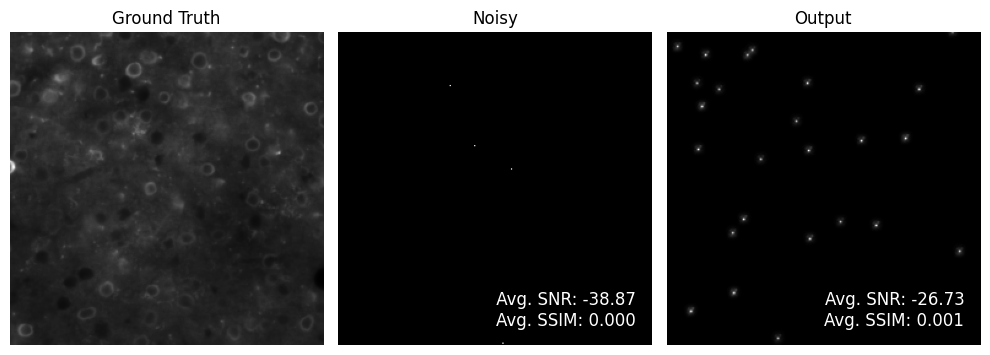

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 11.264878273010254
Denoised mean: 24.12247085571289


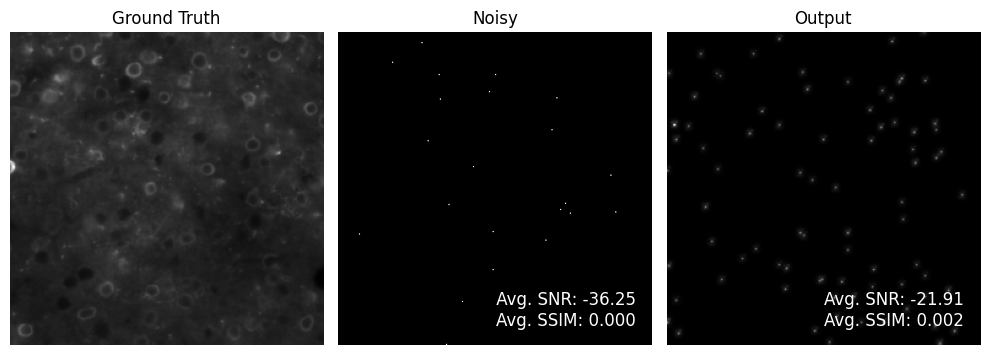

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 8.697509765625
Denoised mean: 23.060766220092773


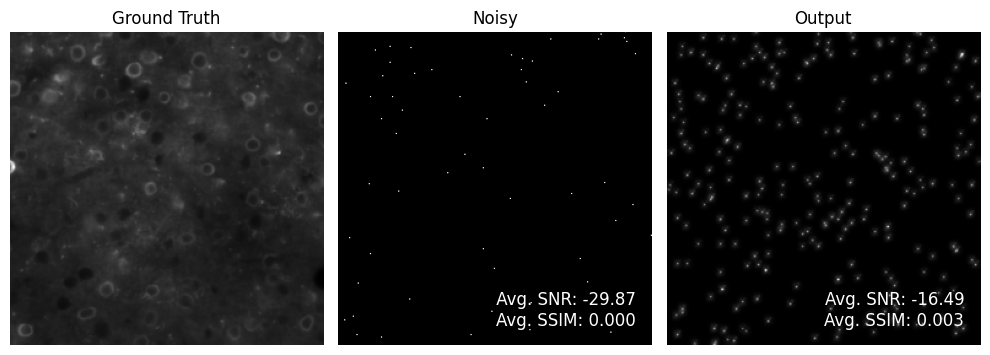

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 9.358724594116211
Denoised mean: 19.51667594909668


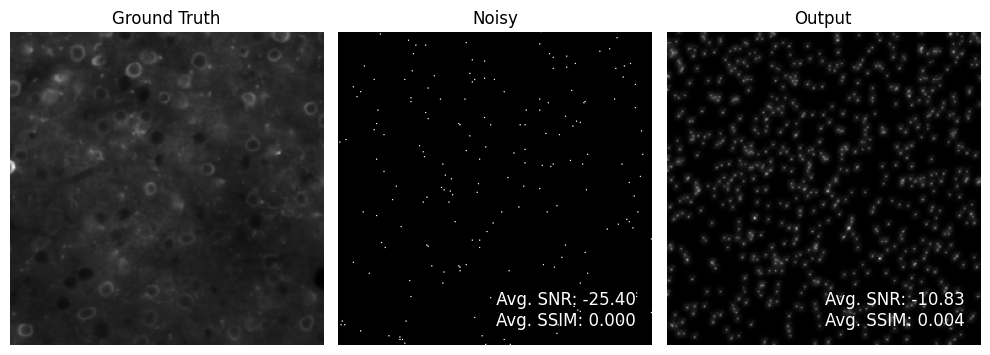

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 8.85009765625
Denoised mean: 16.399738311767578


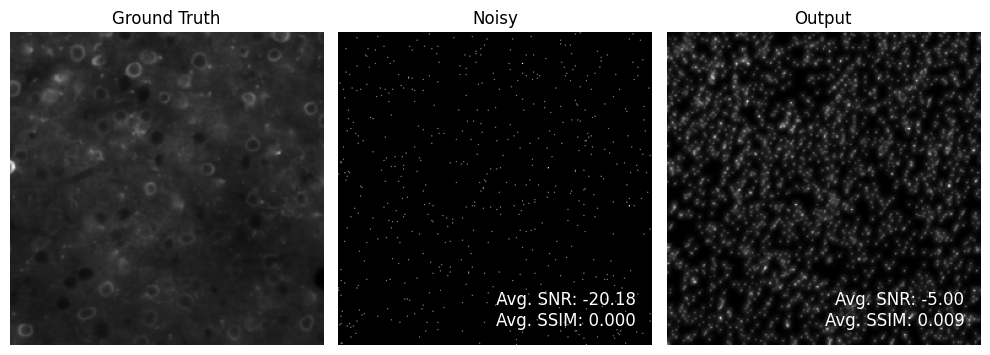

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 9.368896484375
Denoised mean: 11.909076690673828


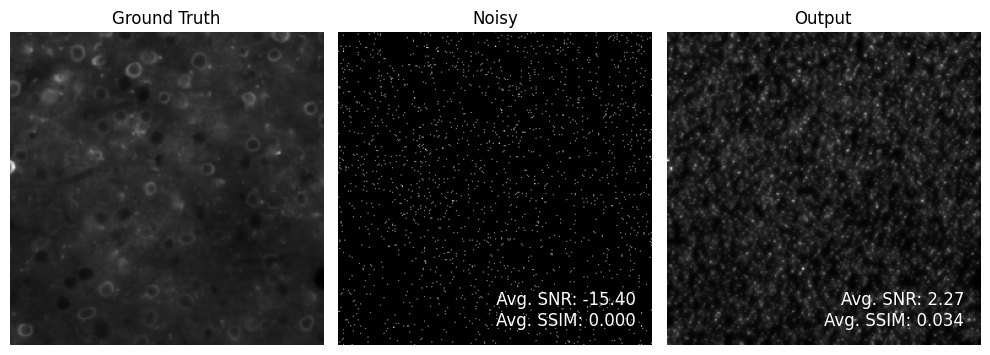

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 9.097451210021973
Denoised mean: 8.01014518737793


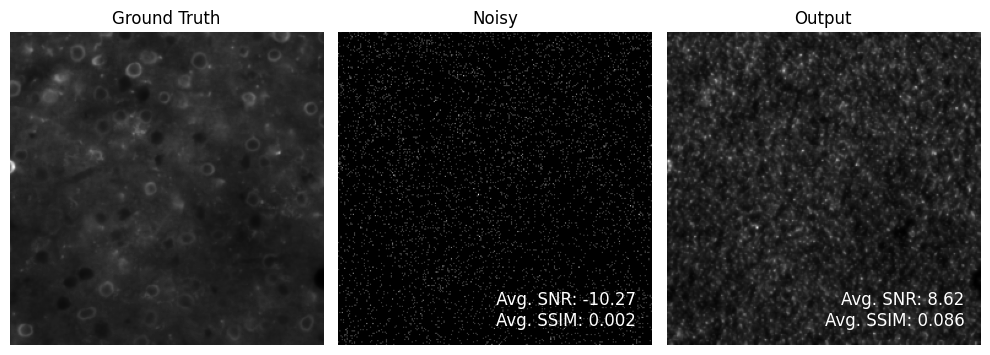

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 9.254964828491211
Denoised mean: 6.926914215087891


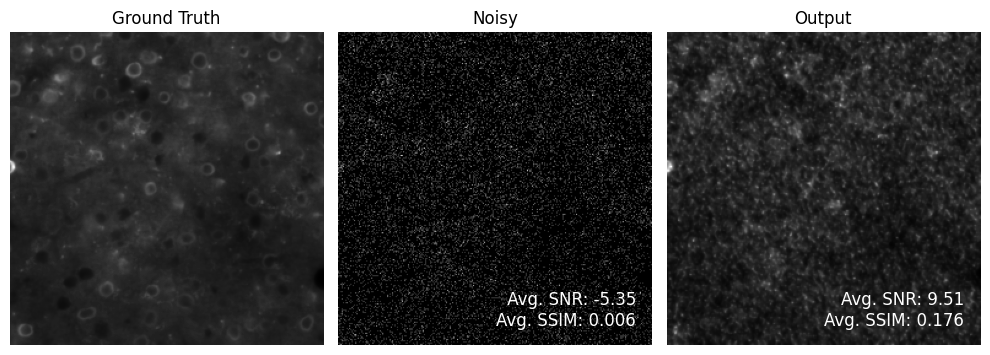

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 9.13628101348877
Denoised mean: 8.27920150756836


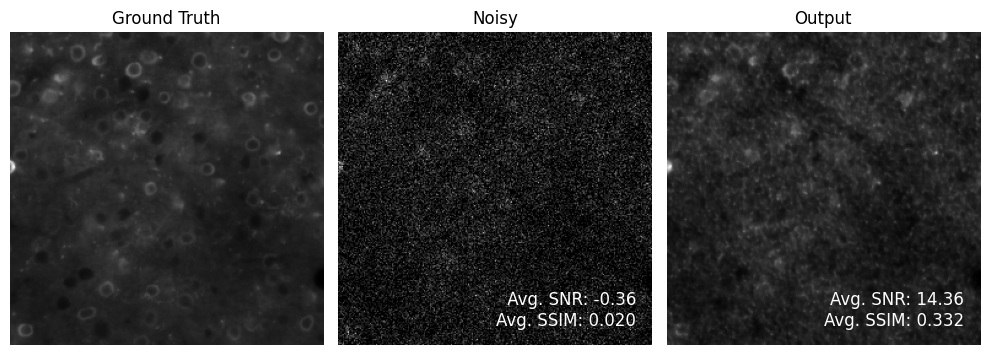

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 9.097494125366211
Denoised mean: 9.012895584106445


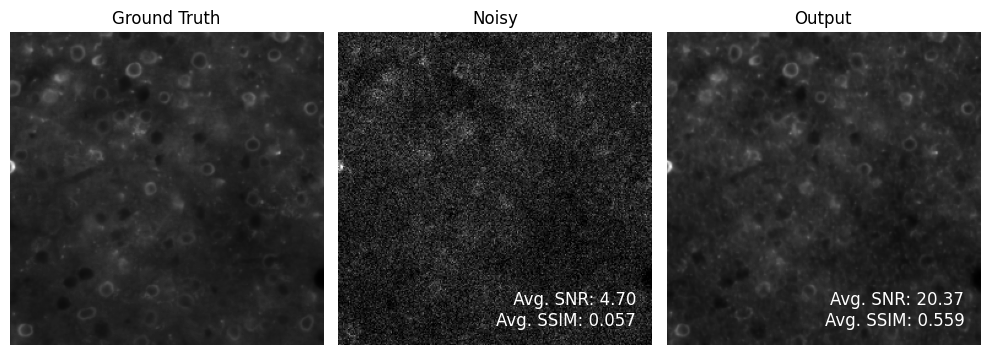

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 9.113287925720215
Denoised mean: 9.107629776000977


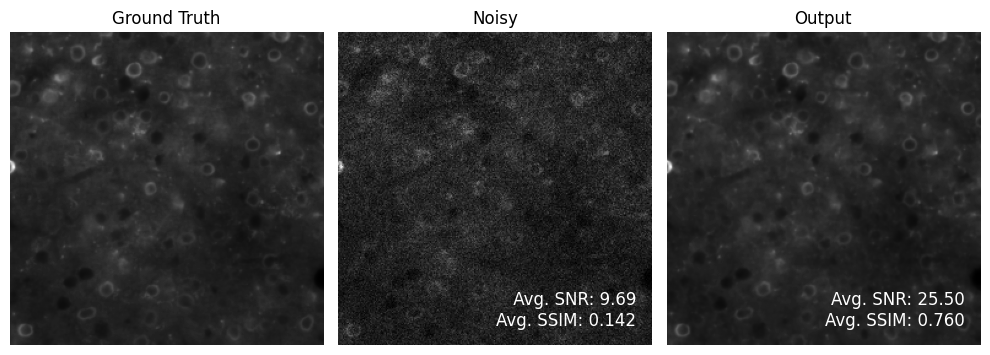

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
GT mean: 9.12043571472168
Noisy mean: 9.119366645812988
Denoised mean: 9.101123809814453


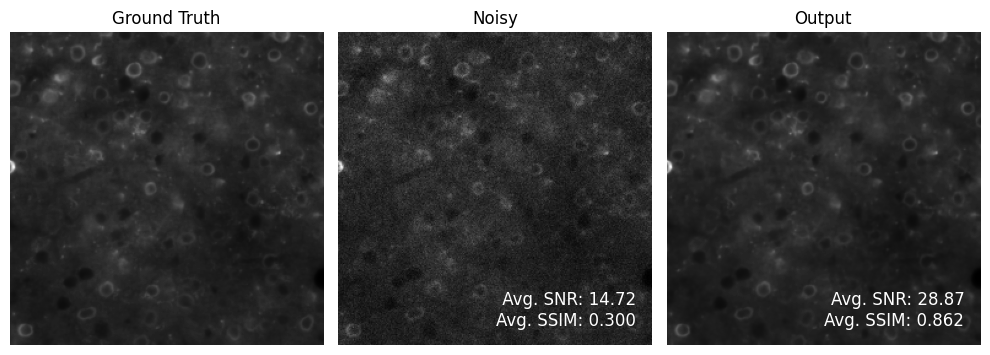

In [ ]:

checkpoint_path = "NONE"

model =  Denoiser.load_from_checkpoint(os.path.join(checkpoint_path)).to(device)
model.eval()

snr_values = []
ssim_values = []

test_range = snr_keys_test = list(test_dict.keys())
print(f"Testing PSNRs {test_range}")

for psnr in test_range:
  noisy_test = test_dict[psnr]["noisy_test"].unsqueeze(0)
  gt_test    = test_dict[psnr]["gt_test"].unsqueeze(0)
  imgs = noisy_test[:,:n_frames,...]
  imgs = imgs.permute(1,0,2,3)

  outputs = []
  with torch.no_grad():
          imgs = imgs.to('cuda')
          output = model(imgs)
          output = output.squeeze(0).squeeze(0)
          output = output.cpu().numpy()


          outputs.append(torch.tensor(output))


  # output is middle frame.
  outputs= torch.stack(outputs)



  gt_img = gt_test[:,n_frames//2,...]
  noisy_img = noisy_test[:,n_frames//2,...]



  noisy_snr = calculate_snr(gt_img, noisy_img)
  denoised_snr = calculate_snr(gt_img, outputs)
  print(noisy_img.shape)
  print(outputs.shape)
  print(gt_img.shape)

  ## SSIM
  ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0)
  ssim_noisy = ssim_metric(gt_img.unsqueeze(1), noisy_img.unsqueeze(1))
  ssim_denoised = ssim_metric(gt_img.unsqueeze(1), noisy_img.unsqueeze(1))
  print(f'noisy ')


  # Create a Matplotlib figure
  plt.figure(figsize=(10, 5))

  image_index = 3

  gt_img =gt_img.squeeze(0)
  noisy_img = noisy_img.squeeze(0)
  outputs = outputs.squeeze(0)
  # Ground Truth
  plt.subplot(1, 3, 1)
  plt.imshow(gt_img, cmap='gray')
  plt.title('Ground Truth')
  plt.axis('off')

  # Noisy Image
  plt.subplot(1, 3, 2)
  plt.imshow(noisy_img, cmap='gray')
  plt.title('Noisy')
  plt.axis('off')
  plt.text(0.95, 0.05, f" Avg. SNR: {noisy_snr:.2f}\nAvg. SSIM: {ssim_noisy:.3f}" , color='white', fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes)

  # Denoised Image (Output)
  plt.subplot(1, 3, 3)
  plt.imshow(outputs, cmap='gray')
  plt.title('Output')
  plt.axis('off')
  plt.text(0.95, 0.05, f"Avg. SNR: {denoised_snr:.2f}\nAvg. SSIM: {ssim_denoised:.3f}", color='white', fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes)

  # Adjust layout
  plt.tight_layout()

  # Specify the path where the image will be saved
  save_path = f'/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/UMVD/{psnr} Out: {denoised_snr:.2f} .png'


  # Save the figure as a PNG file
  #plt.savefig(save_path, format='png', dpi=300)

  # Optionally, display the plot
  plt.show()



  # Append SNR values to the list

  snr_values.append((psnr,denoised_snr))
  ssim_values.append((psnr,ssim_denoised))

  # Close the figure to free up memory
  plt.close()


<ipython-input-14-8d066055593e>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(temporalfilter(n_frames, mid, LEVEL, MINV)).unsqueeze(1).float().to(device)


torch.Size([5, 1, 256, 256])


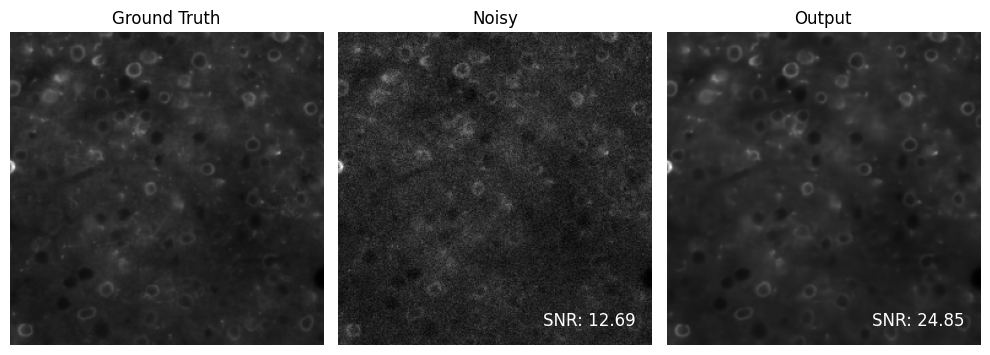

SNR of Noisy: 12.69
SNR of Denoised: 24.85


In [ ]:

checkpoint_path = "/content/drive/MyDrive/MastersThesis/Analysis/Checkpoints/UMVD: Params: 1731759, n_frames: 5, Filters 21, Level:64/epoch=9-val_loss=102148.58.ckpt"

model =  Denoiser.load_from_checkpoint(os.path.join(checkpoint_path)).to(device)
model.eval()

snr_values = []
ssim_values = []

test_range = snr_keys_test = list(test_dict.keys())
print(f"Testing PSNRs {test_range}")

for pnsr in test_range:
  noisy_test = test_dict[psnr]["noisy_test"].unsqueeze(0)
  gt_test    = test_dict[psnr]["gt_test"].unsqueeze(0)
  imgs = noisy_test[:n_frames,...]
  outputs = []
  with torch.no_grad():

          imgs = imgs.to('cuda')
          print(imgs.shape)
          output = model(imgs)
          output = output.squeeze(0).squeeze(0)
          output = output.cpu().numpy()


          outputs.append(torch.tensor(output))


  # output is middle frame.
  outputs= torch.stack(outputs)
  gt_img = gt_test[n_frames//2,...]
  noisy_img = noisy_test[n_frames//2,...]



  noisy_snr = calculate_snr(gt_img, noisy_img)
  denoised_snr = calculate_snr(gt_img, outputs)

  ## SSIM
  ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0)
  ssim_noisy = ssim_metric(gt_img.unsqueeze(1), noisy_img.unsqueeze(1))
  ssim_denoised = ssim_metric(gt_img.unsqueeze(1), noisy_img.unsqueeze(1))
  average_ssim_noisy = ssim_noisy.mean().item()
  average_ssim_denoised = ssim_denoised.mean().item()


  # Create a Matplotlib figure
  plt.figure(figsize=(10, 5))

  image_index = 3


  # Ground Truth
  plt.subplot(1, 3, 1)
  plt.imshow(gt_img[image_index], cmap='gray')
  plt.title('Ground Truth')
  plt.axis('off')

  # Noisy Image
  plt.subplot(1, 3, 2)
  plt.imshow(noisy_test_GAP[image_index], cmap='gray')
  plt.title('Noisy')
  plt.axis('off')
  plt.text(0.95, 0.05, f" Avg. SNR: {noisy_snr:.2f}\nAvg. SSIM: {average_ssim_noisy:.3f}" , color='white', fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes)

  # Denoised Image (Output)
  plt.subplot(1, 3, 3)
  plt.imshow(output_GAP[image_index], cmap='gray')
  plt.title('Output')
  plt.axis('off')
  plt.text(0.95, 0.05, f"Avg. SNR: {denoised_snr:.2f}\nAvg. SSIM: {average_ssim_denoised:.3f}", color='white', fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes)

  # Adjust layout
  plt.tight_layout()

  # Specify the path where the image will be saved
  save_path = f'/content/drive/MyDrive/MastersThesis/Analysis/data/NAOMi/GAP PSNR -40/-40 SNR IN: {psnr} Out: {denoised_snr:.2f} .png'


  # Save the figure as a PNG file
  plt.savefig(save_path, format='png', dpi=300)

  # Optionally, display the plot
  #plt.show()



  # Append SNR values to the list

  snr_values.append((psnr,denoised_snr))
  ssim_values.append((psnr,average_ssim_denoised))

  # Close the figure to free up memory
  plt.close()
